In [122]:
#NOTE: Trained on the filtered CGM data

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from Glucose_processor import GlucoseDataProcessor
from models.model_B import BloodGlucosePredictorB

In [123]:
# Define prediction horizons (in minutes, adjust as needed)
horizons = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]

# Initialize the BloodGlucosePredictor
bg_predictor = BloodGlucosePredictorB(horizons=horizons)

In [124]:
Glucose_data = GlucoseDataProcessor(CGM_file_path="CGM_data.csv", bolus_file_path="Bolus_data.csv", carb_file_path="Carb_data.csv",
                                    min_range=69, max_range=180, target=85, tp=75, td=280, dp=45, dd=180)


df = Glucose_data.create_filtered_DataFrame()

df

Time         CGM  Insulin Activity  Food Activity
3255  2024-12-09 01:57:16   74.633941          0.000000       0.000000
3254  2024-12-09 02:02:16   77.013161          0.000000       0.000000
3253  2024-12-09 02:07:16   79.895722          0.000000       0.000000
3252  2024-12-09 02:12:16   83.361943          0.000000       0.000000
3251  2024-12-09 02:17:16   87.477852          0.000000       0.000000
...                   ...         ...               ...            ...
4     2024-12-20 13:51:28  149.673834          0.032914       0.130190
3     2024-12-20 13:56:27  152.754635          0.032283       0.123480
2     2024-12-20 14:01:27  155.653519          0.031558       0.116350
1     2024-12-20 14:06:27  158.336854          0.030786       0.108902
0     2024-12-20 14:11:27  160.773267          0.029946       0.101206

[3256 rows x 4 columns]

In [125]:
# Preprocess the data
X_scaled, y_scaled = bg_predictor.preprocess_data(df)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Build the model
input_shape = (1, X_train.shape[1])  # Shape required for LSTM (timesteps=1, features=X_train.shape[1])
bg_predictor.build_model(input_shape=input_shape)

d:\DiaPulse\models\model_B.py:21: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)  # Linear interpolation for missing values
d:\DiaPulse\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [126]:
# Train the model
model_save_path = 'saved_models/model_B.keras'
history = bg_predictor.train(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=200,
    model_save_path=model_save_path
)

history

Epoch 1/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1190 - mae: 0.2927 - val_loss: 0.0441 - val_mae: 0.1518
Epoch 2/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0275 - mae: 0.1231 - val_loss: 0.0322 - val_mae: 0.1379
Epoch 3/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0209 - mae: 0.1075 - val_loss: 0.0315 - val_mae: 0.1347
Epoch 4/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0213 - mae: 0.1077 - val_loss: 0.0315 - val_mae: 0.1318
Epoch 5/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0185 - mae: 0.1004 - val_loss: 0.0289 - val_mae: 0.1301
Epoch 6/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0173 - mae: 0.0971 - val_loss: 0.0274 - val_mae: 0.1250
Epoch 7/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0173 - mae: 0.0972 - val_loss: 0.0250 - val_mae: 0.1192
Epoch 8/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0161 - mae: 0.0927 - val_loss: 0.0206 - val_mae: 0.1094
Epoch 9/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.014

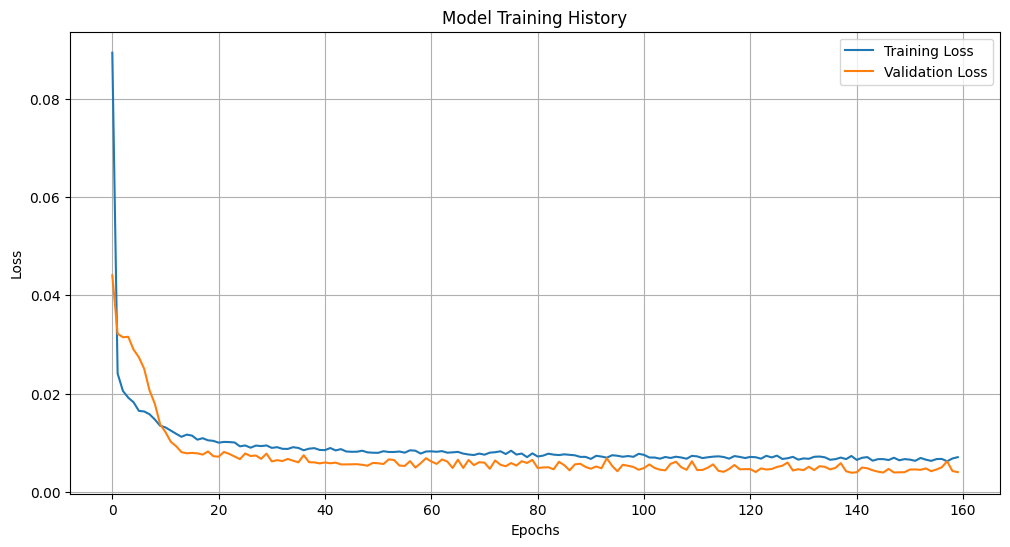

In [138]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [128]:
# Evaluate the model on test data
loss, mae = bg_predictor.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

Test Loss: 0.0037, Test MAE: 0.0420


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


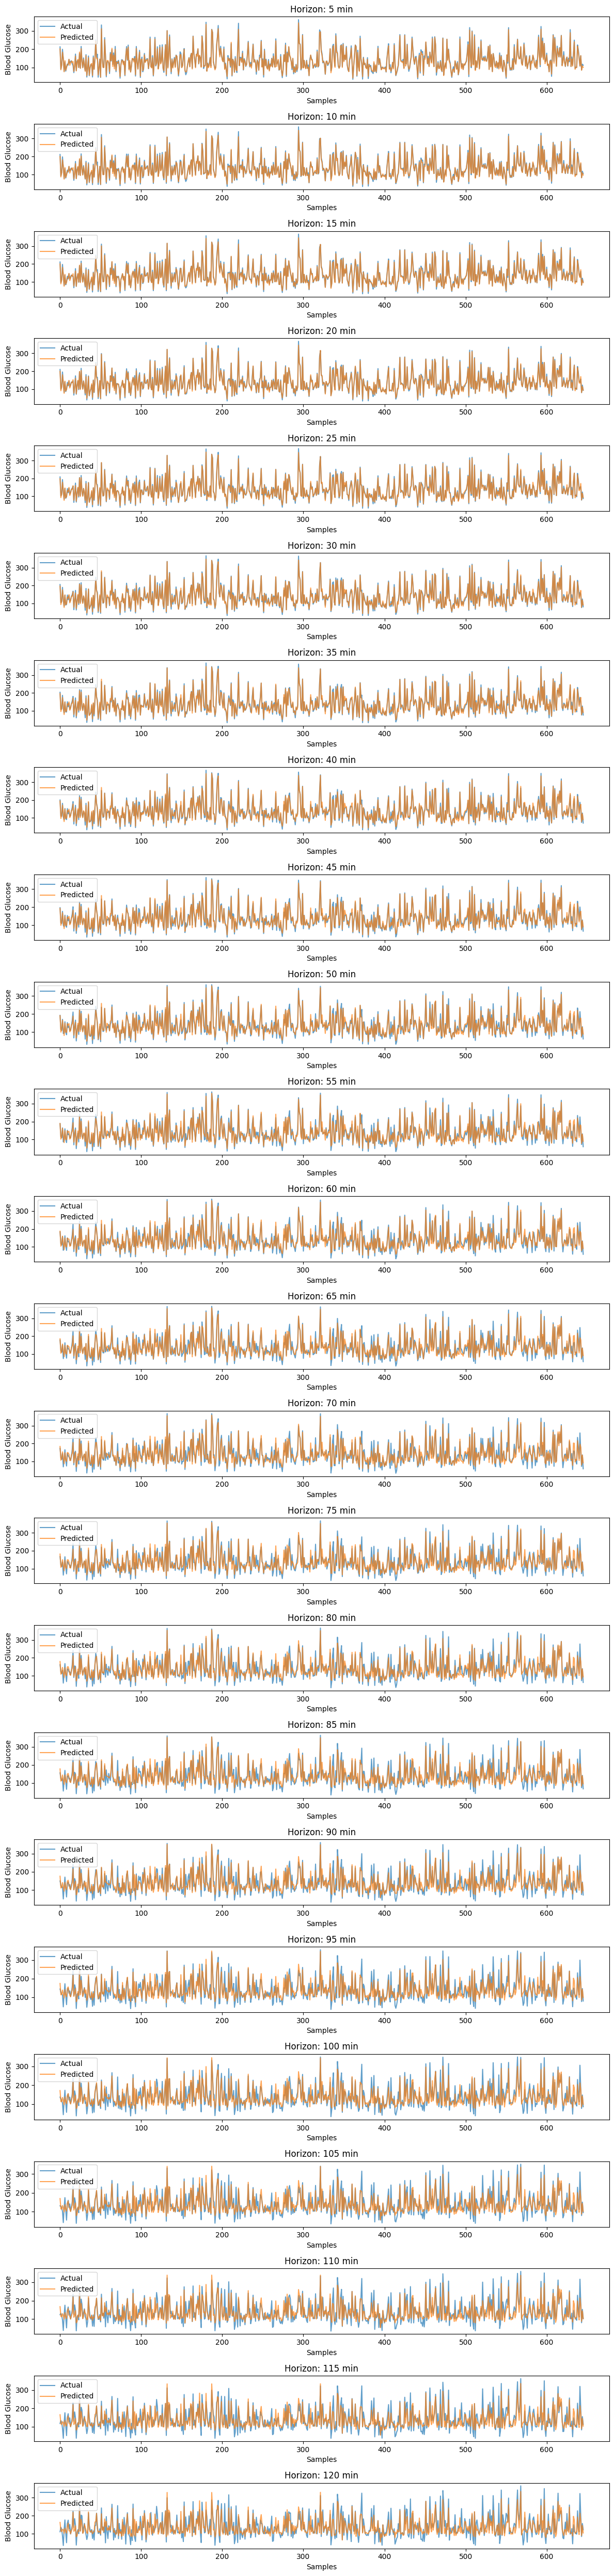

In [129]:
# Make predictions on test data
y_pred = bg_predictor.predict(X_test)

# Visualize predictions vs actual
plt.figure(figsize=(12, 50))
for i, horizon in enumerate(horizons):
    plt.subplot(len(horizons), 1, i + 1)
    plt.plot(bg_predictor.scaler_y.inverse_transform(y_test)[:, i], label='Actual', alpha=0.7)
    plt.plot(y_pred[:, i], label='Predicted', alpha=0.7)
    plt.title(f'Horizon: {horizon} min')
    plt.xlabel('Samples')
    plt.ylabel('Blood Glucose')
    plt.legend()
    plt.tight_layout()
plt.show()

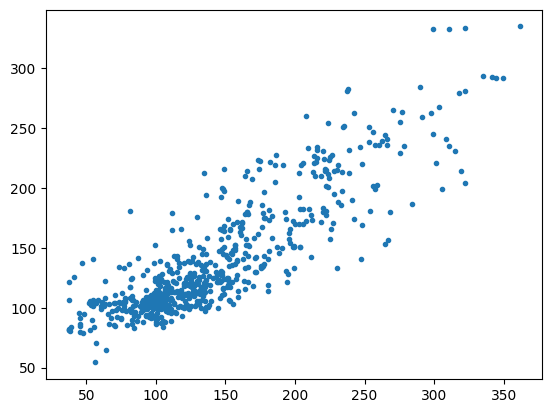

In [130]:
plt.figure()

i = 22 # Where {0: 5 min, 1: 10 min, 2: 15 min, ... 22: 120 min}

plt.plot(bg_predictor.scaler_y.inverse_transform(y_test)[:, i], y_pred[:, i], ".")

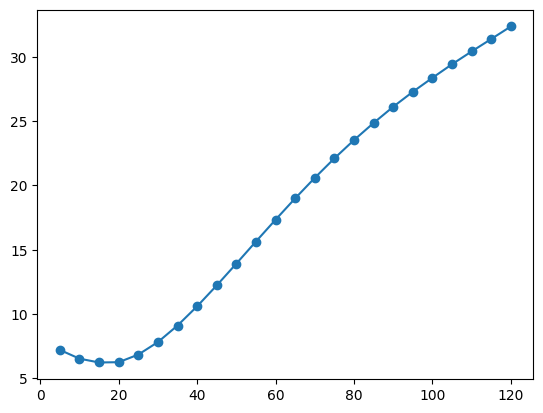

In [131]:
# Find RMSE of every horizon

from sklearn.metrics import mean_squared_error

rmse = []

for i, horizon in enumerate(horizons):
    actual = bg_predictor.scaler_y.inverse_transform(y_test)[:, i]
    pred = y_pred[:, i]
    rmse.append(np.sqrt(mean_squared_error(actual, pred)))


plt.plot(horizons, rmse, "o-")

horizons       MAE
0          5  2.398369
1         10  2.283059
2         15  2.229012
3         20  2.226898
4         25  2.330381
5         30  2.500177
6         35  2.705505
7         40  2.920709
8         45  3.129871
9         50  3.332407
10        55  3.522765
11        60  3.699315
12        65  3.865456
13        70  4.017601
14        75  4.154695
15        80  4.275524
16        85  4.381276
17        90  4.479872
18        95  4.568312
19       100  4.646398
20       105  4.721935
21       110  4.796262
22       115  4.868469
23       120  4.943983

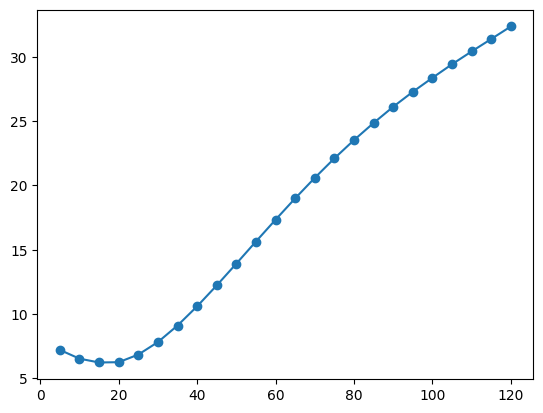

In [132]:
# Find MAE of every horizon

from sklearn.metrics import mean_absolute_error

mae = []

for i, horizon in enumerate(horizons):
    actual = bg_predictor.scaler_y.inverse_transform(y_test)[:, i]
    pred = y_pred[:, i]
    mae.append(np.sqrt(mean_absolute_error(actual, pred)))


plt.plot(horizons, rmse, "o-")

df = pd.DataFrame({"horizons": horizons, "MAE": mae})
df

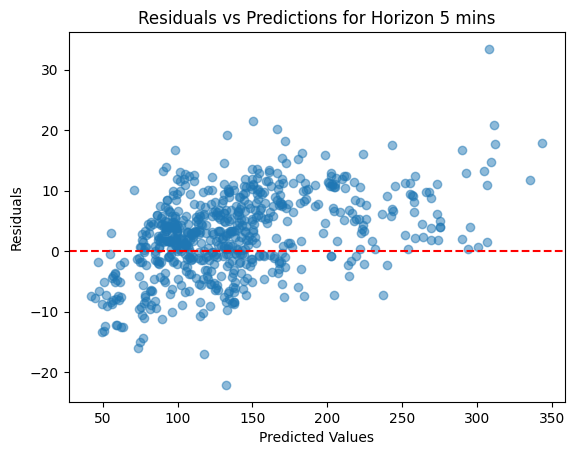

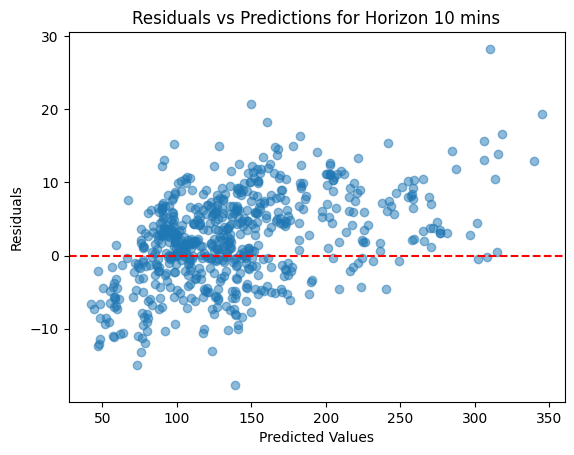

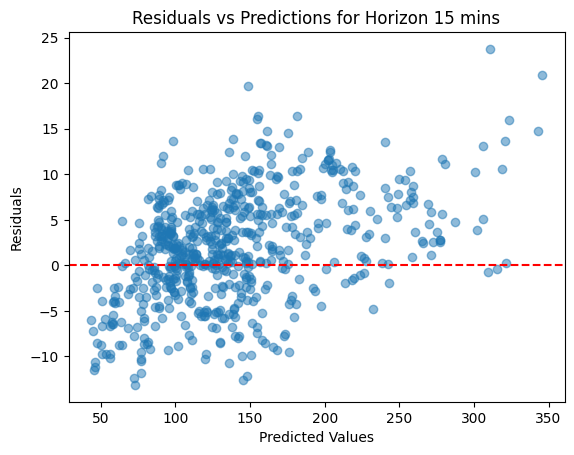

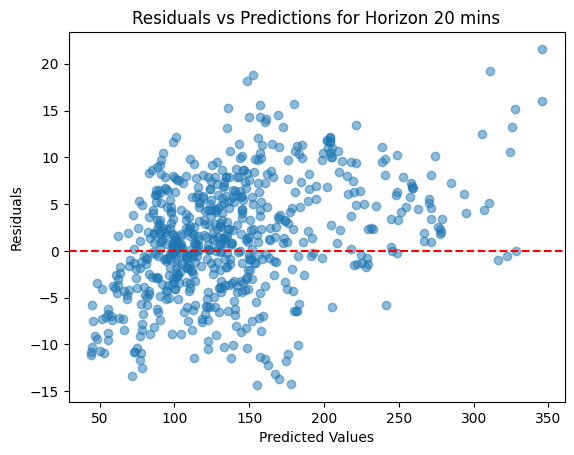

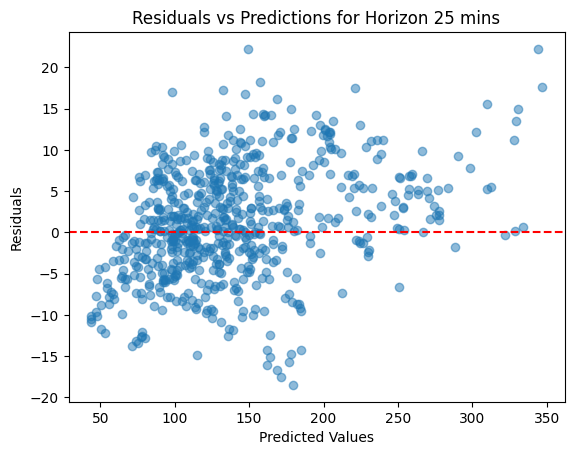

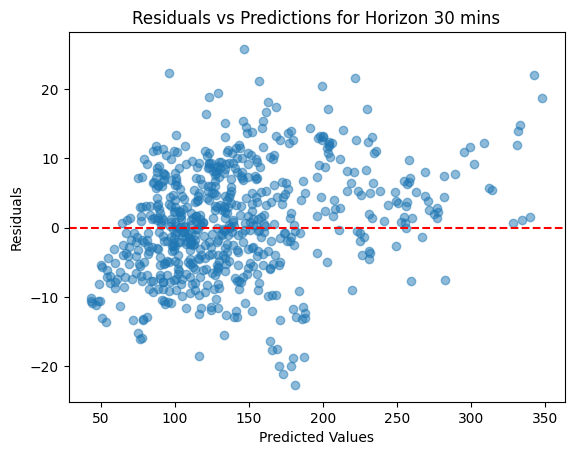

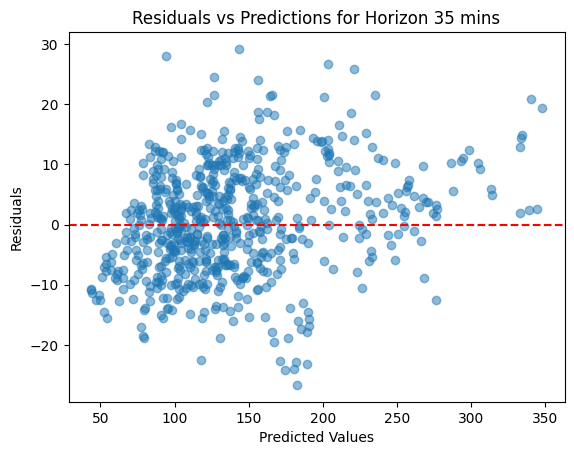

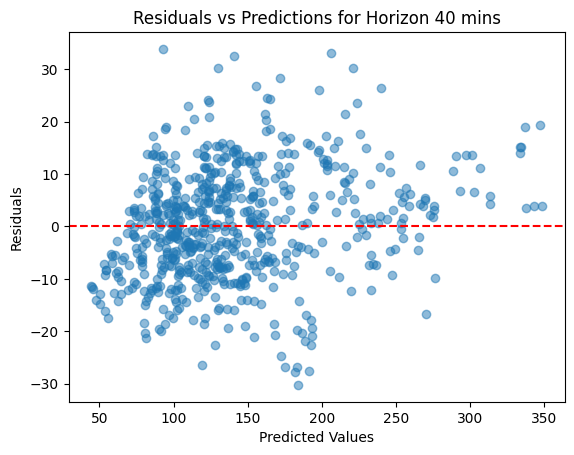

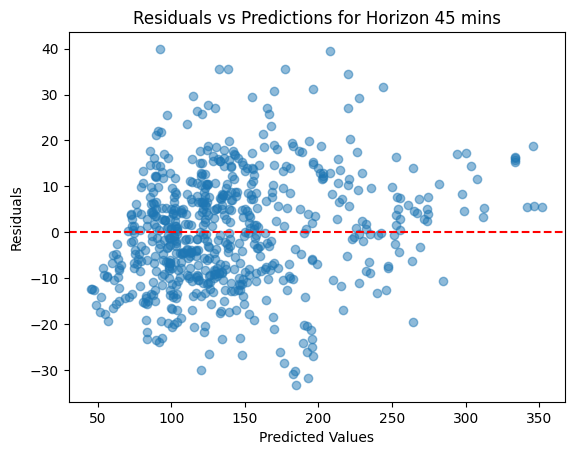

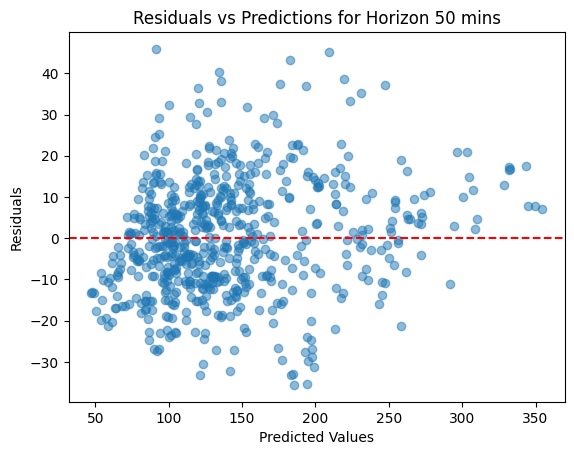

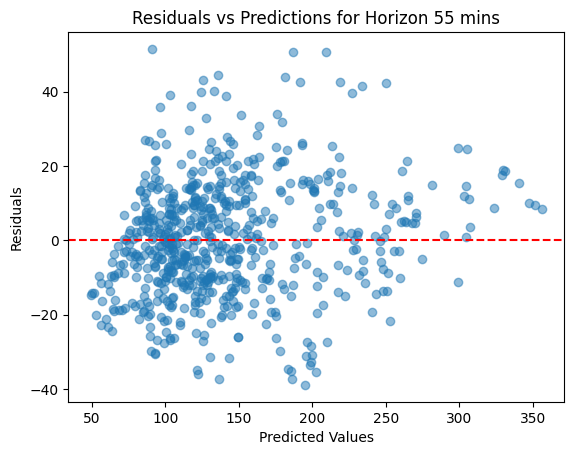

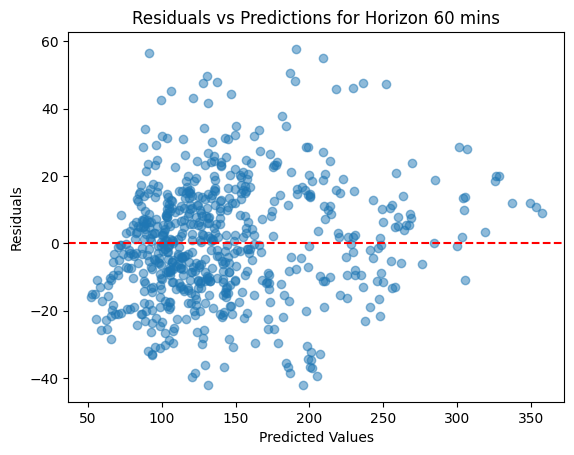

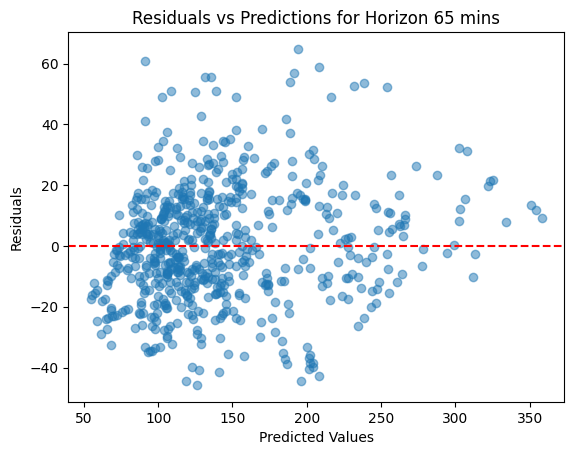

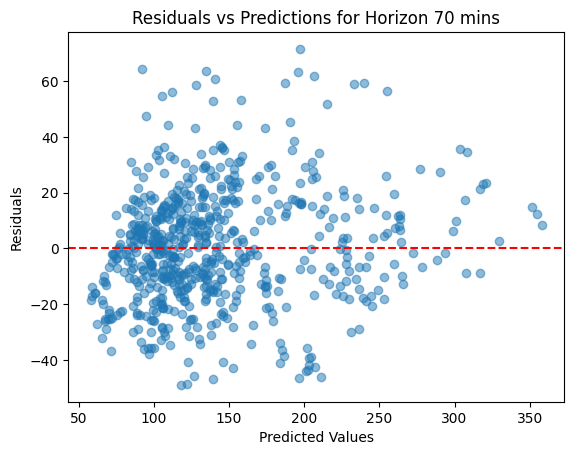

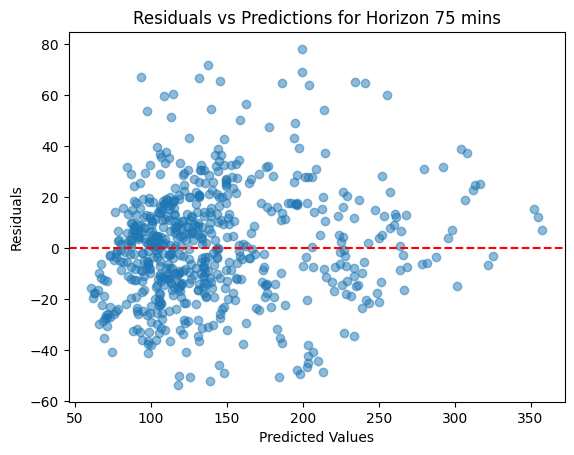

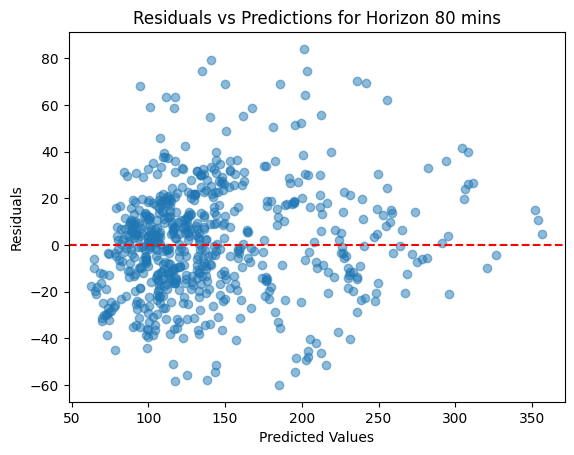

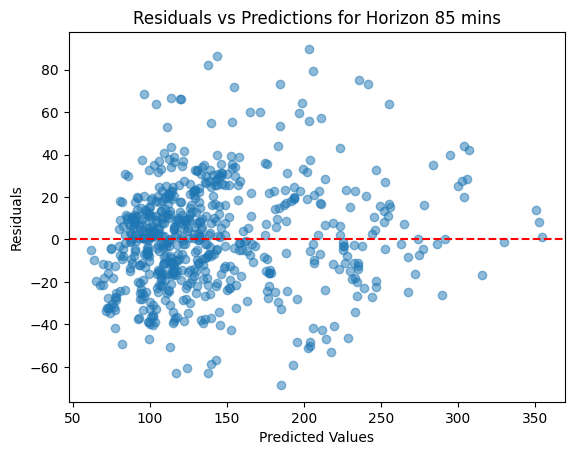

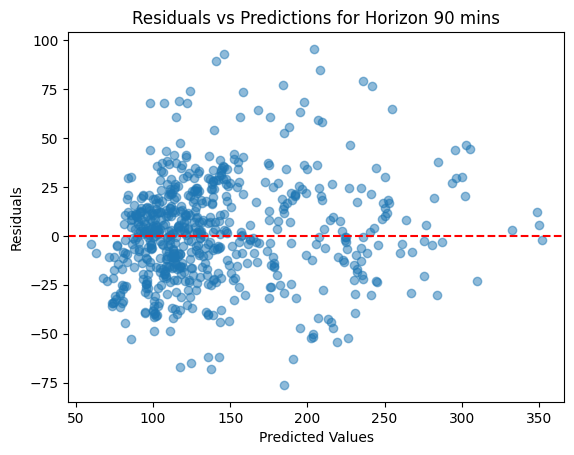

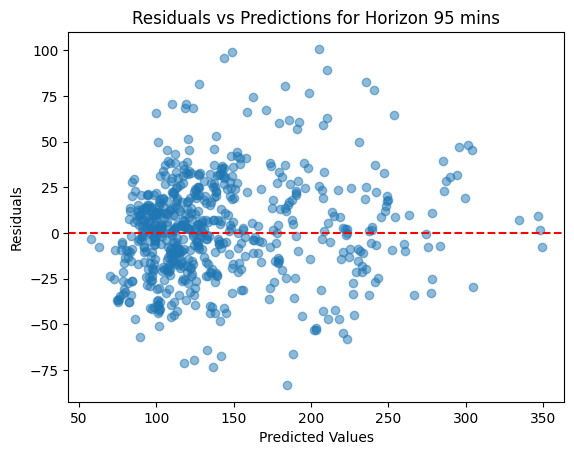

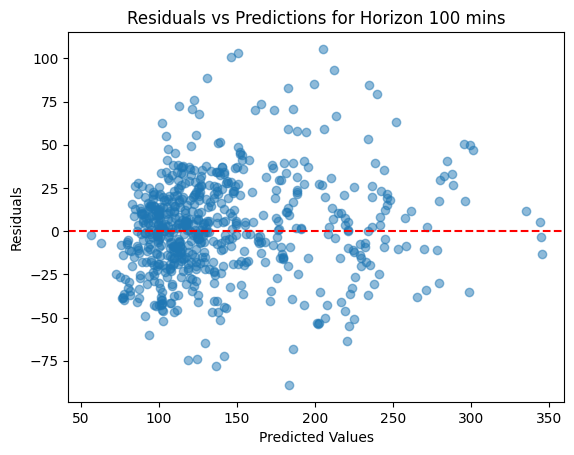

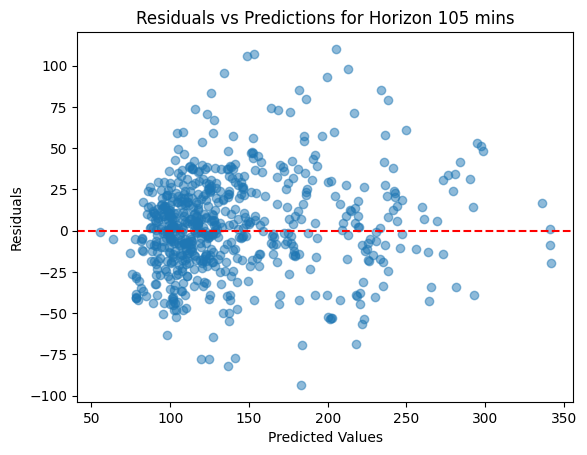

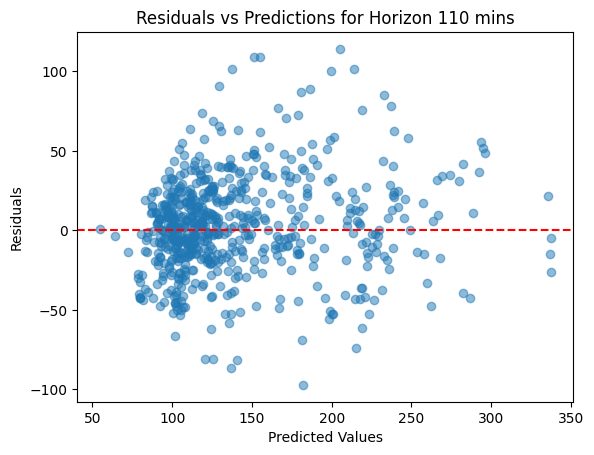

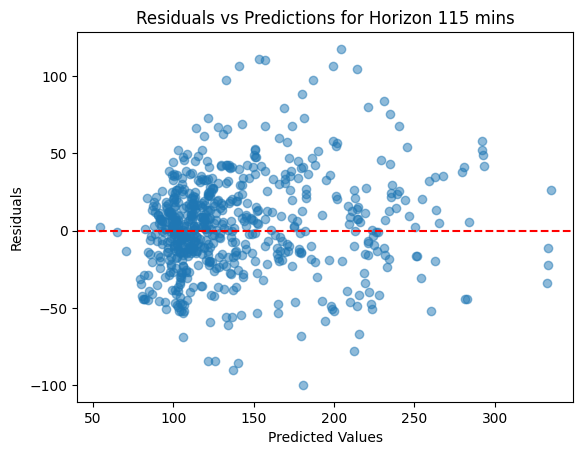

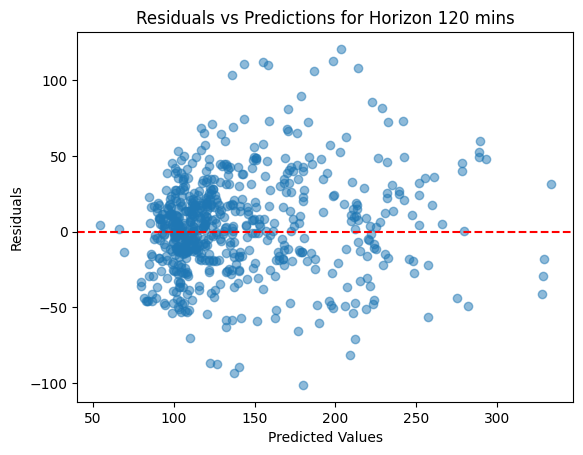

In [133]:
# Residuals

residuals_per_horizon = {f"Horizon_{h}": bg_predictor.scaler_y.inverse_transform(y_test)[:, i] - y_pred[:, i] for i, h in enumerate(horizons)}

for i, h in enumerate(horizons):
    plt.figure()
    plt.scatter(y_pred[:, i], residuals_per_horizon[f"Horizon_{h}"], alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residuals vs Predictions for Horizon {h} mins')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()



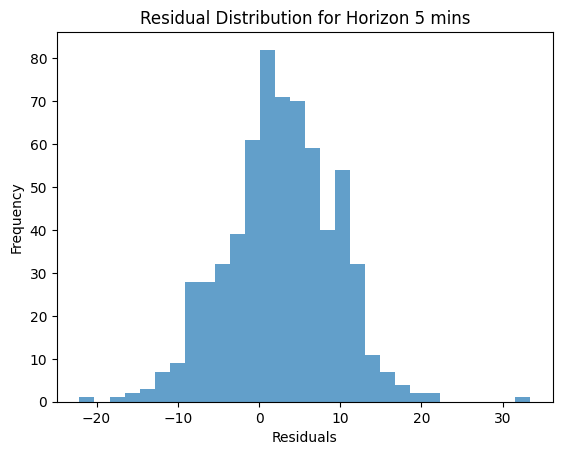

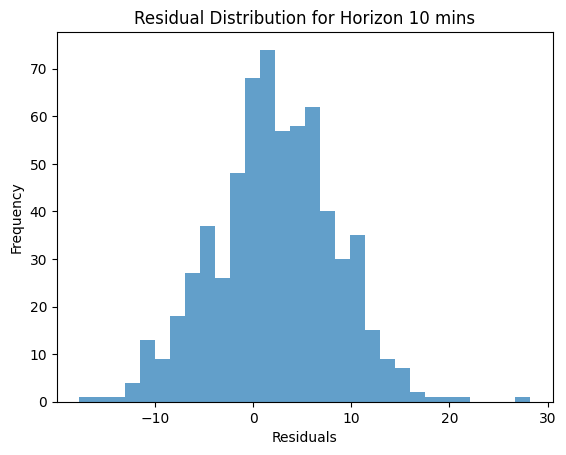

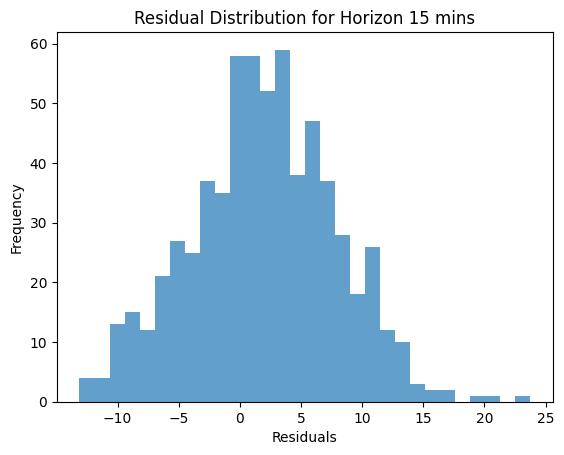

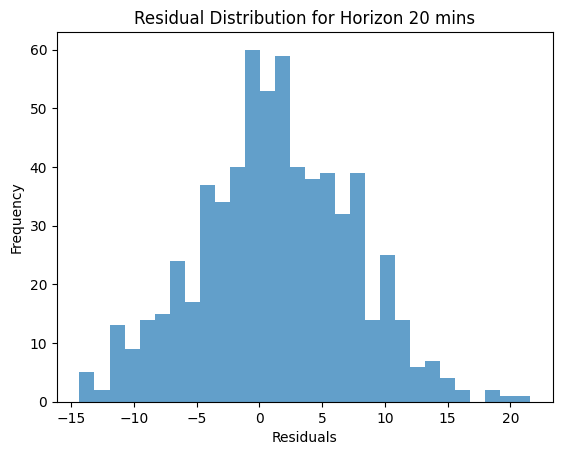

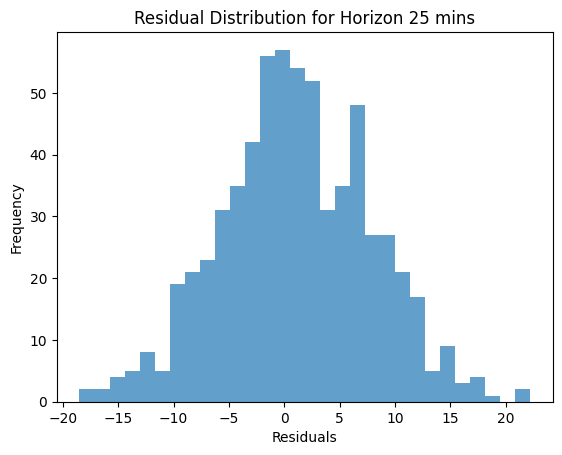

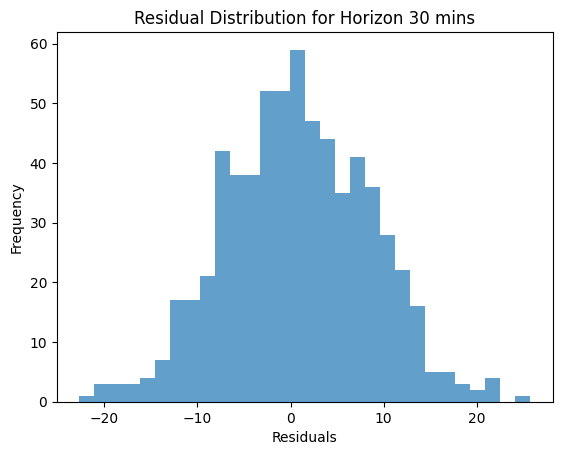

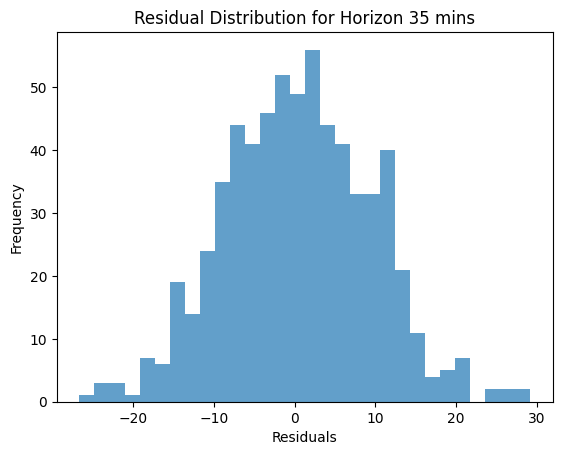

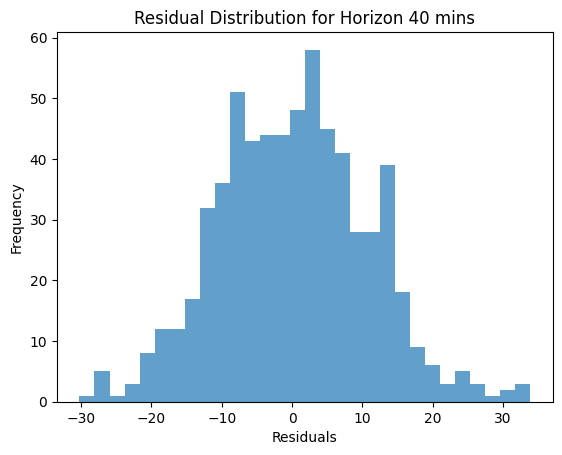

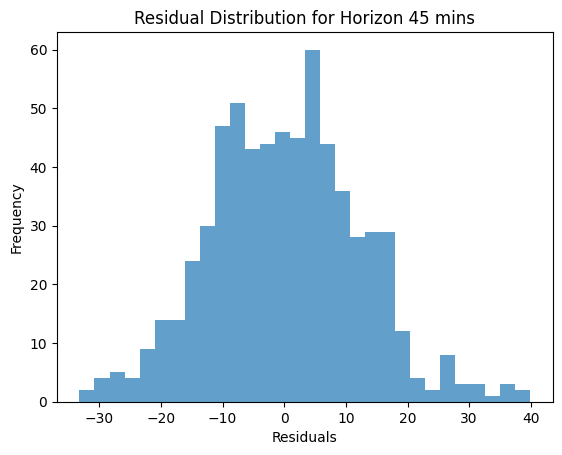

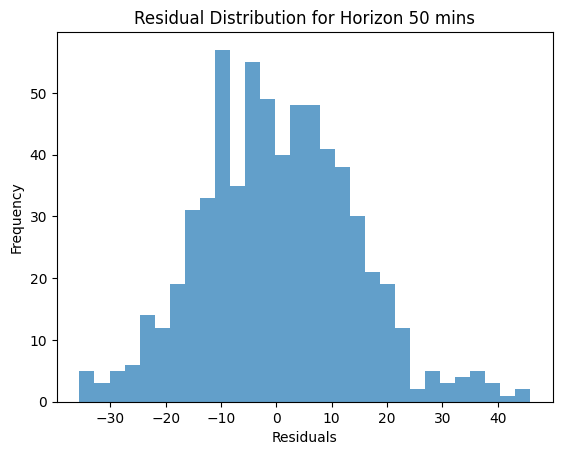

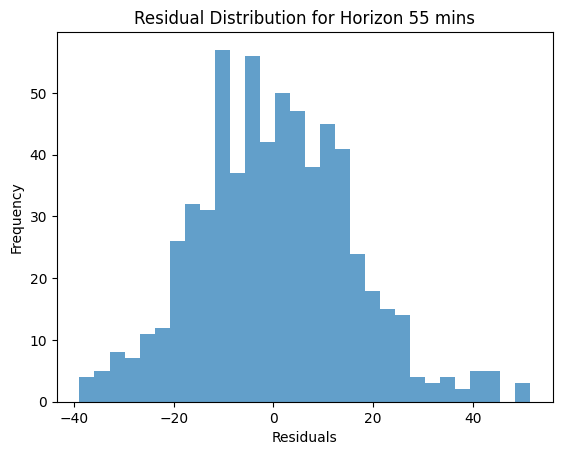

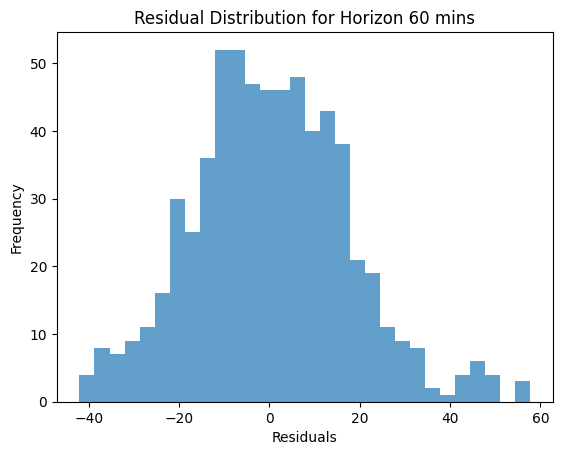

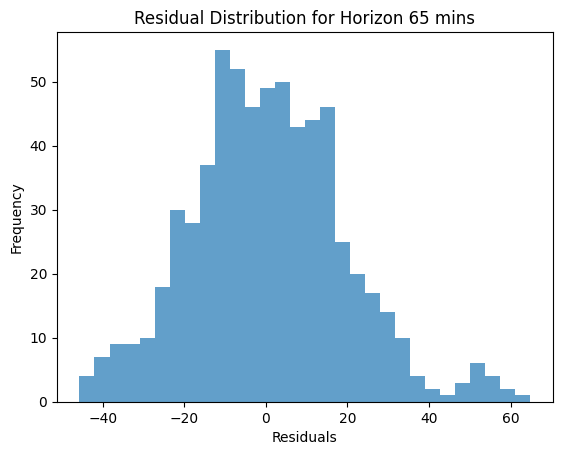

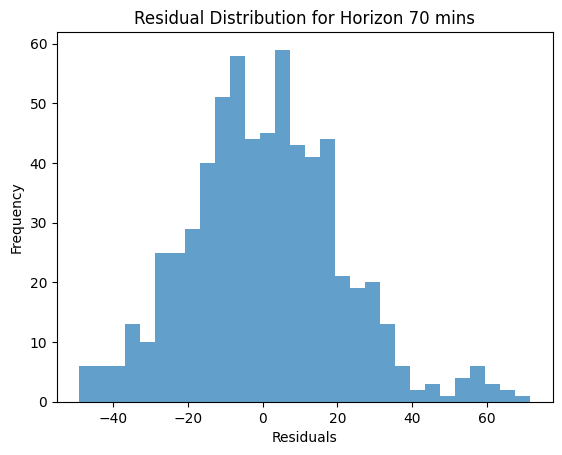

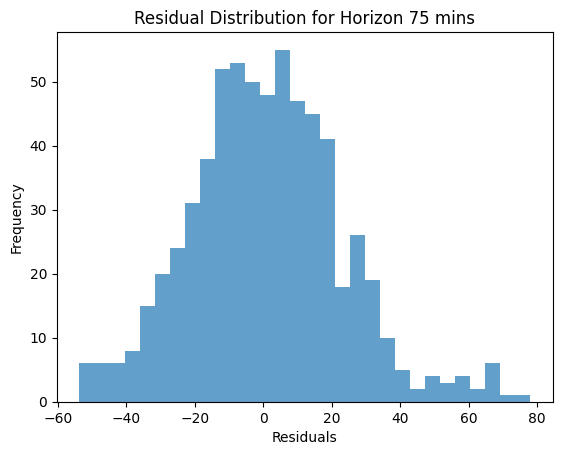

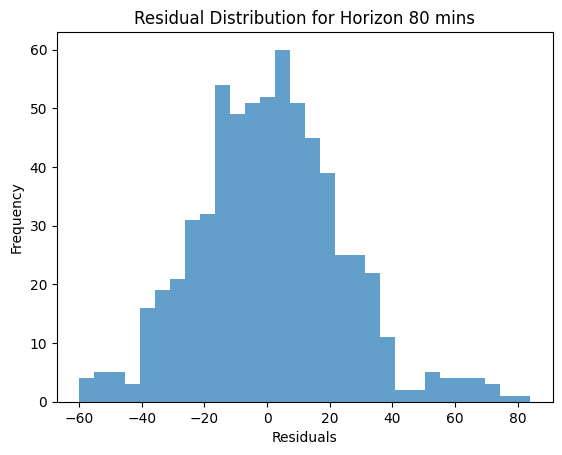

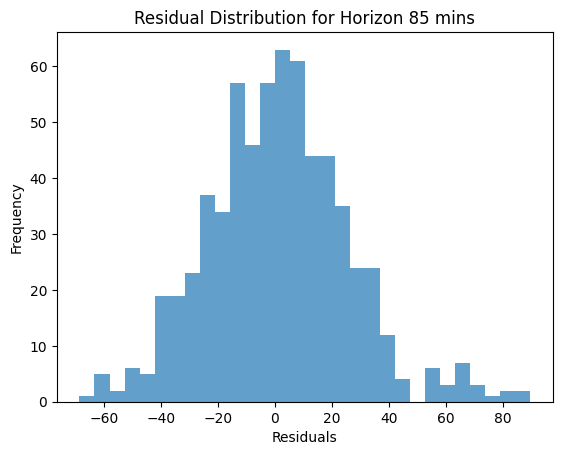

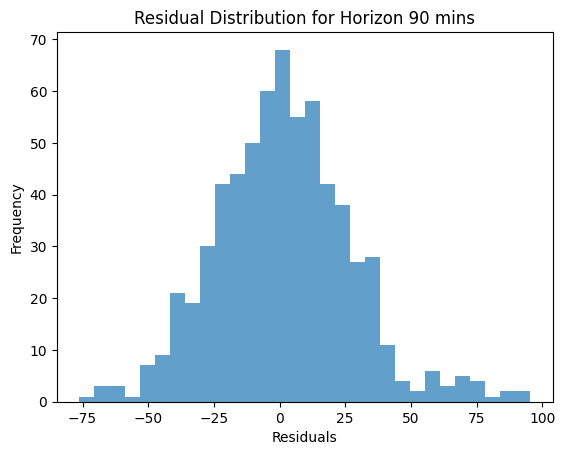

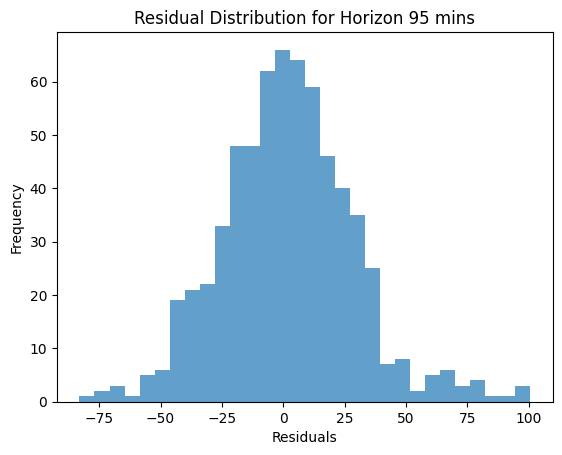

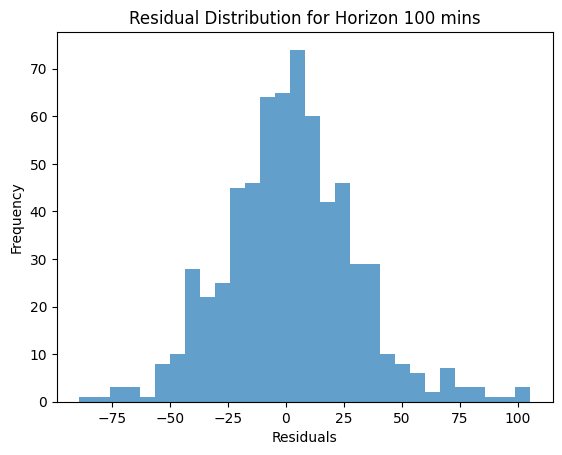

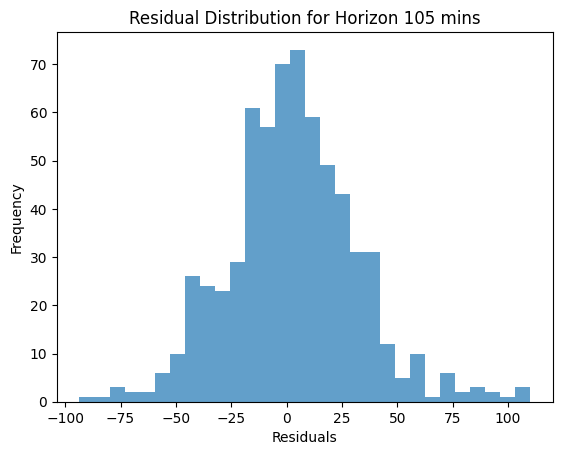

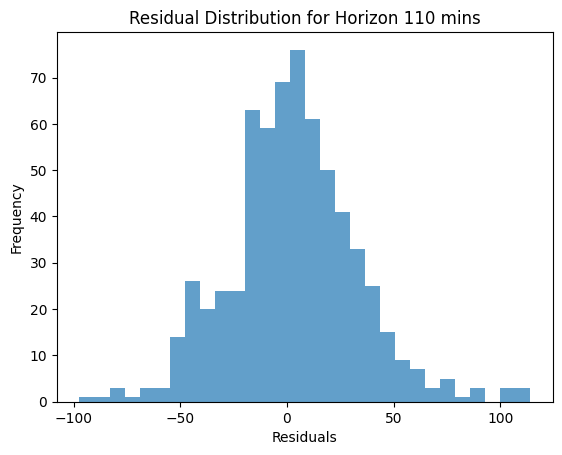

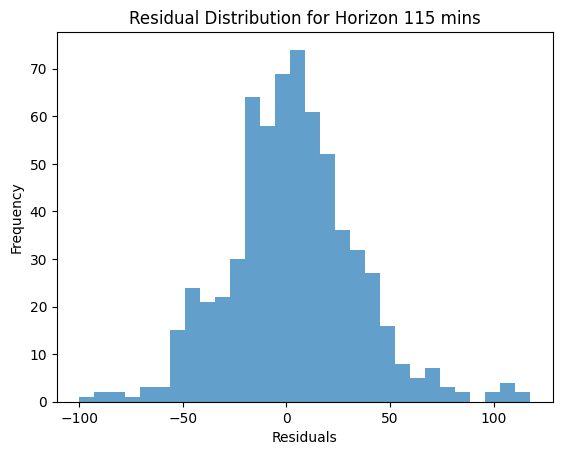

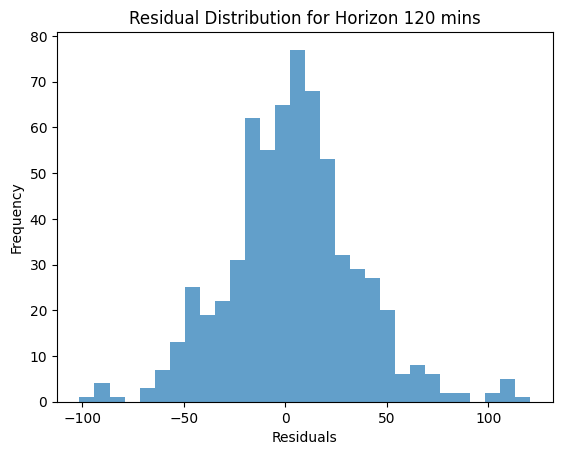

In [134]:
# Histogram of residuals

for i, h in enumerate(horizons):
    plt.figure()
    plt.hist(residuals_per_horizon[f"Horizon_{h}"], bins=30, alpha=0.7)
    plt.title(f'Residual Distribution for Horizon {h} mins')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

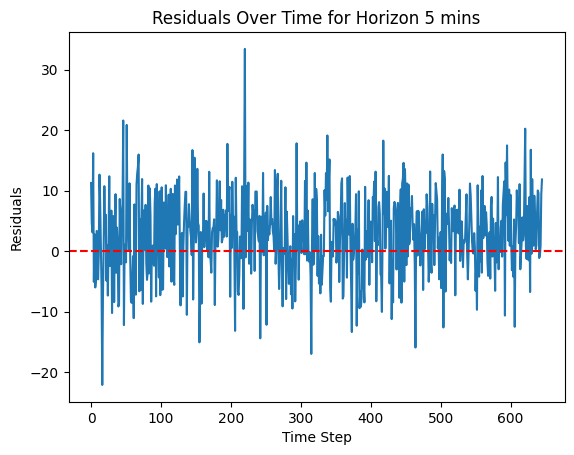

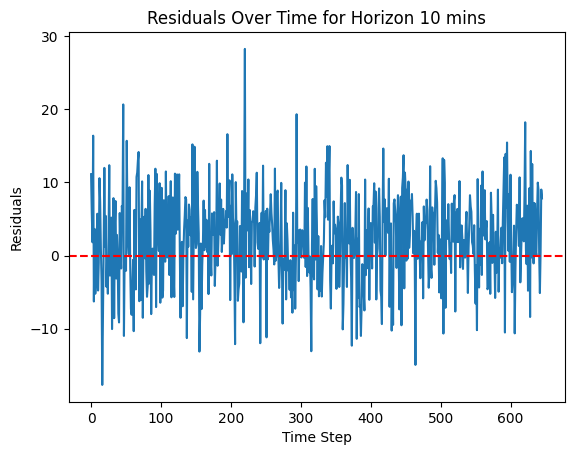

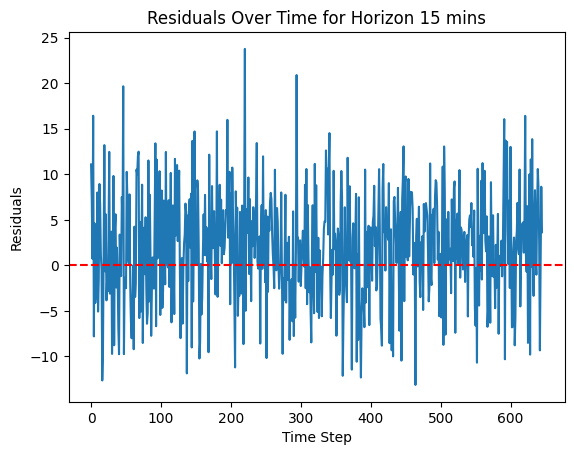

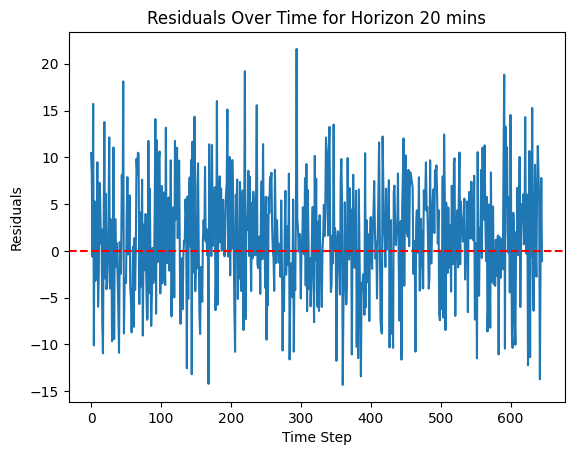

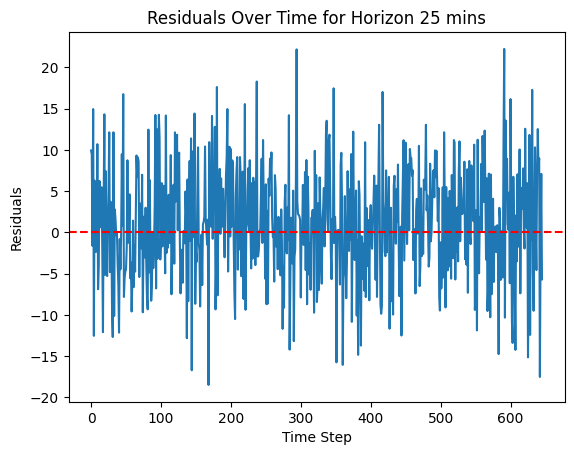

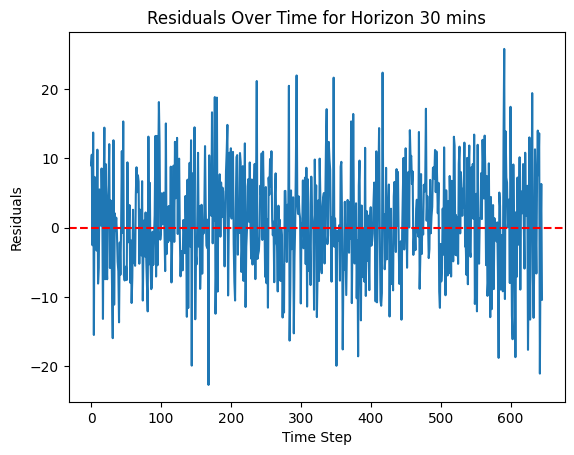

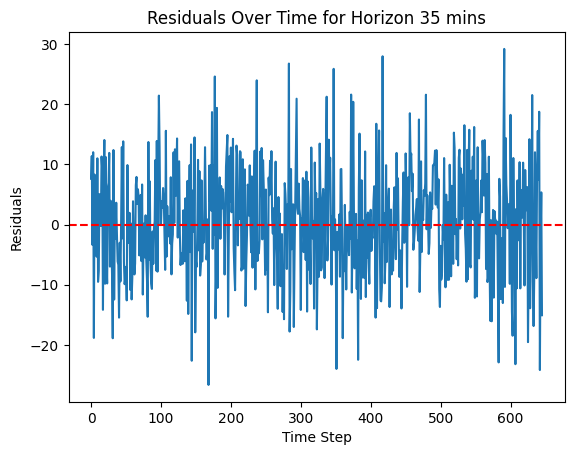

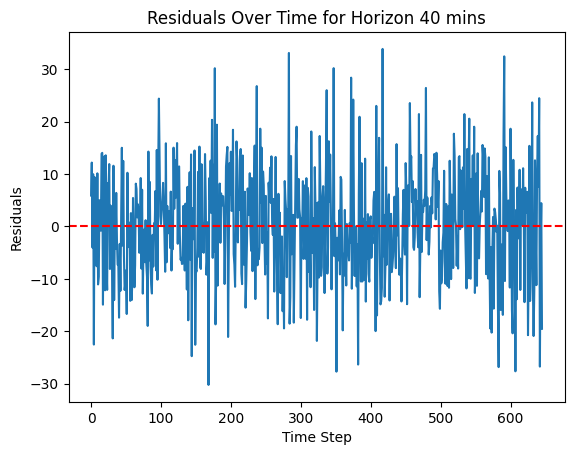

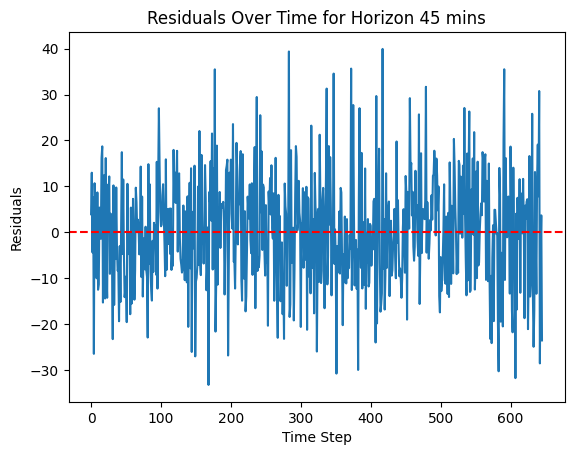

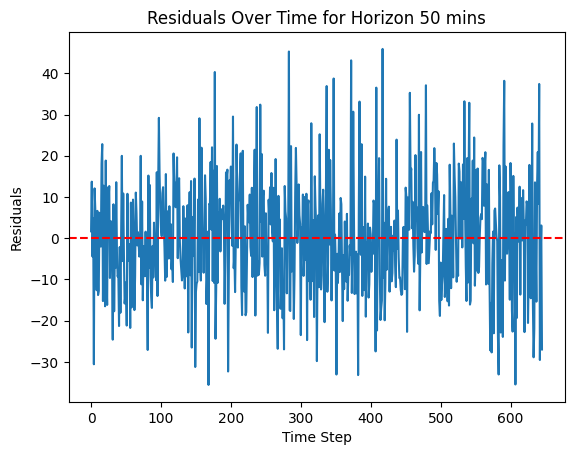

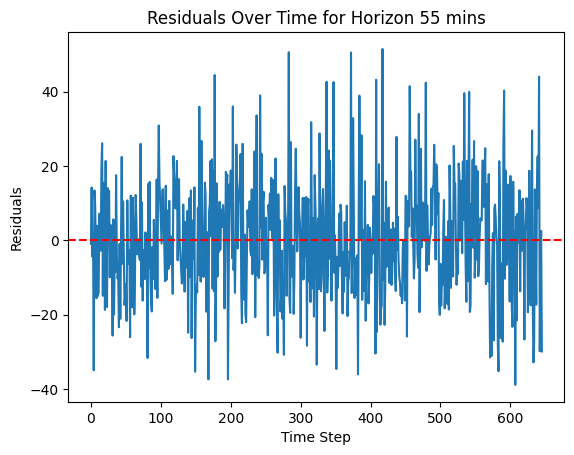

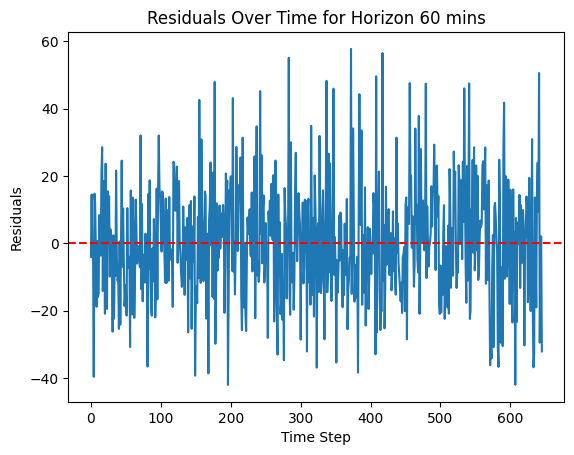

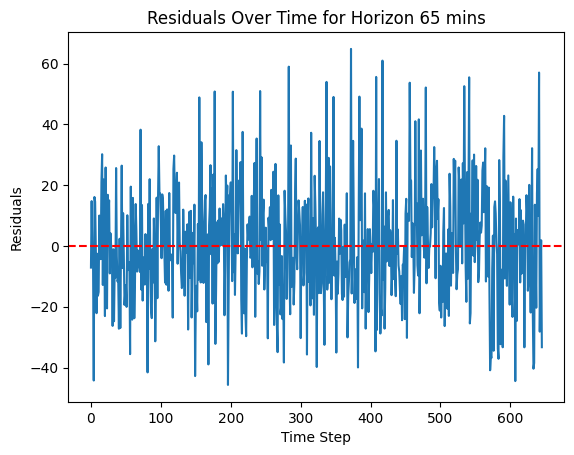

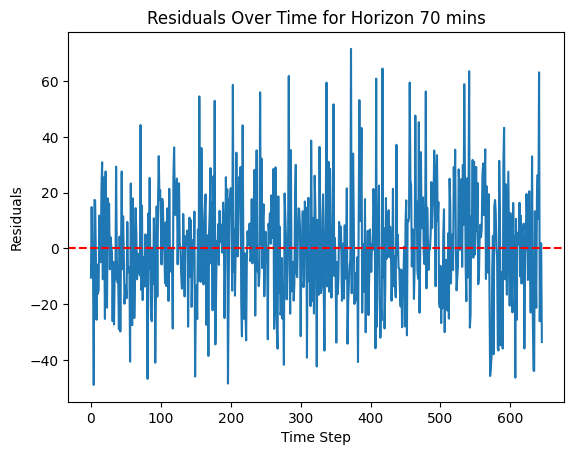

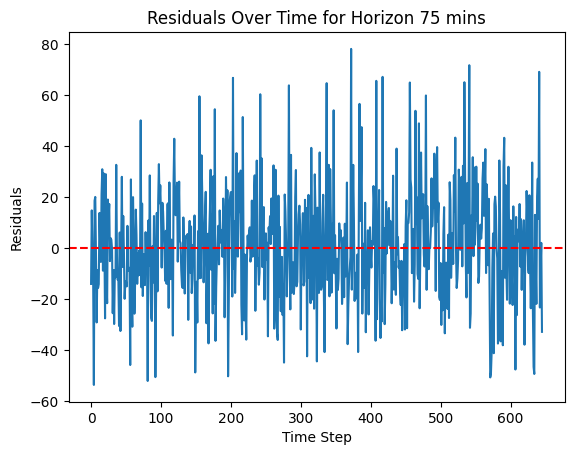

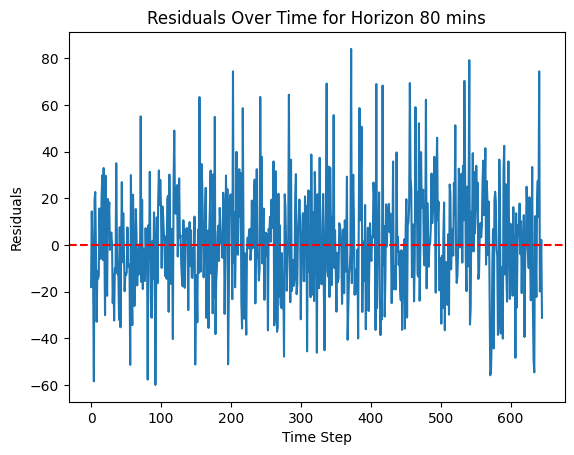

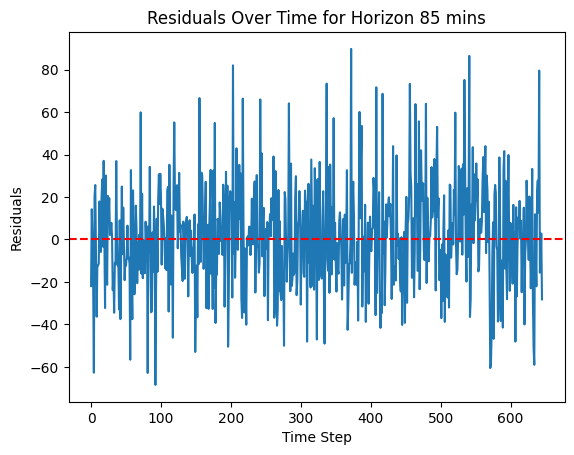

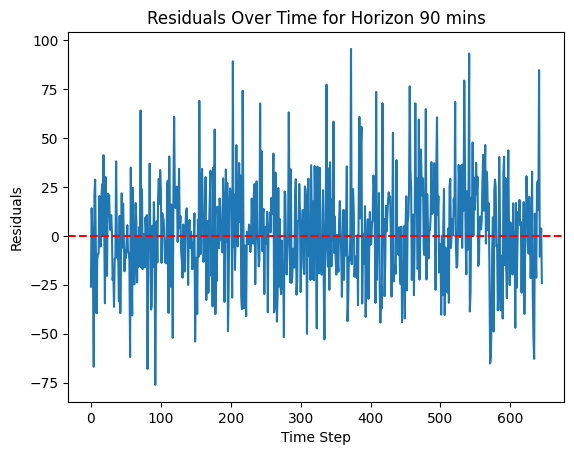

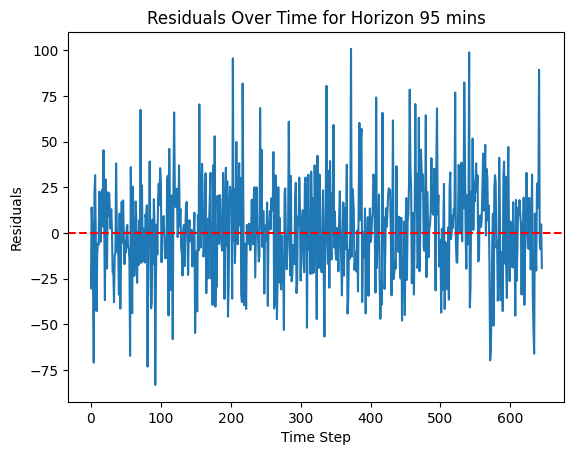

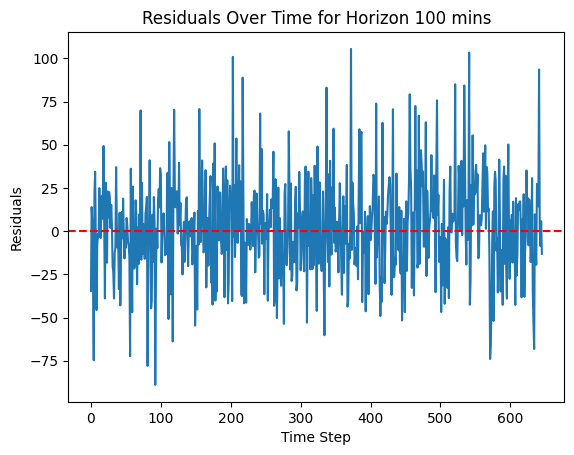

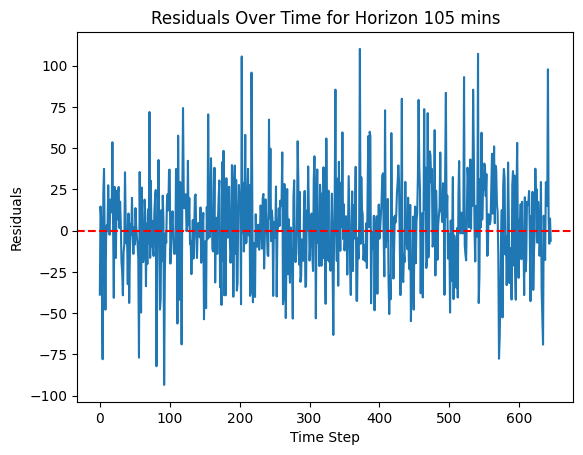

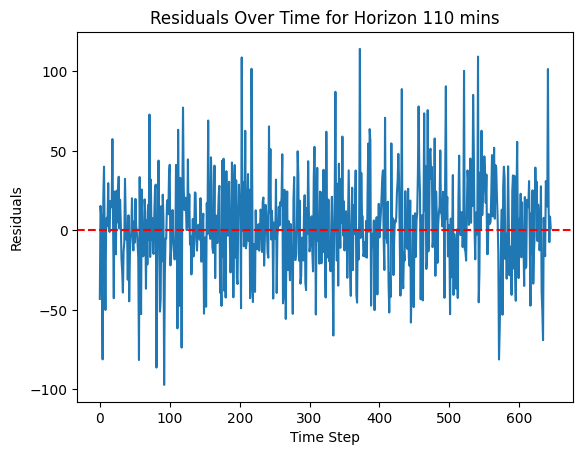

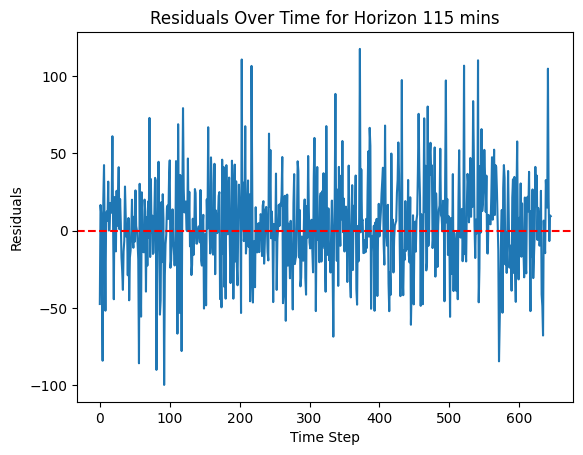

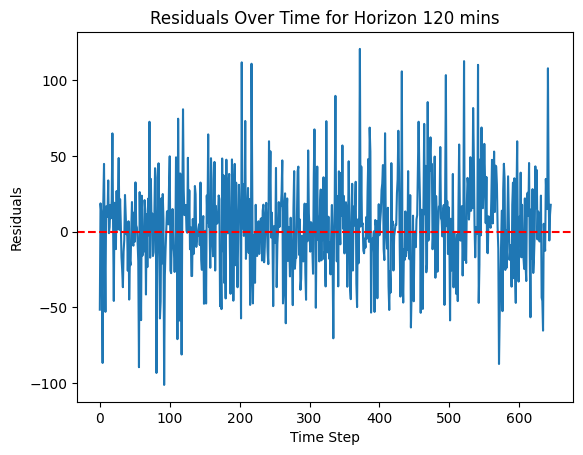

In [135]:
for i, h in enumerate(horizons):
    plt.figure()
    plt.plot(residuals_per_horizon[f"Horizon_{h}"])
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residuals Over Time for Horizon {h} mins')
    plt.xlabel('Time Step')
    plt.ylabel('Residuals')
    plt.show()

In [136]:
for h in horizons:
    res = residuals_per_horizon[f"Horizon_{h}"]
    print(f"Horizon {h} mins: Mean={np.mean(res):.2f}, Std={np.std(res):.2f}")


Horizon 5 mins: Mean=2.69, Std=6.69
Horizon 10 mins: Mean=2.23, Std=6.14
Horizon 15 mins: Mean=1.94, Std=5.93
Horizon 20 mins: Mean=1.35, Std=6.11
Horizon 25 mins: Mean=1.07, Std=6.77
Horizon 30 mins: Mean=0.79, Std=7.78
Horizon 35 mins: Mean=0.49, Std=9.10
Horizon 40 mins: Mean=0.26, Std=10.60
Horizon 45 mins: Mean=0.21, Std=12.23
Horizon 50 mins: Mean=0.27, Std=13.92
Horizon 55 mins: Mean=0.35, Std=15.64
Horizon 60 mins: Mean=0.39, Std=17.33
Horizon 65 mins: Mean=0.58, Std=18.98
Horizon 70 mins: Mean=0.78, Std=20.57
Horizon 75 mins: Mean=0.94, Std=22.08
Horizon 80 mins: Mean=1.05, Std=23.50
Horizon 85 mins: Mean=1.27, Std=24.82
Horizon 90 mins: Mean=1.69, Std=26.06
Horizon 95 mins: Mean=1.95, Std=27.20
Horizon 100 mins: Mean=2.13, Std=28.28
Horizon 105 mins: Mean=2.63, Std=29.30
Horizon 110 mins: Mean=2.89, Std=30.27
Horizon 115 mins: Mean=3.13, Std=31.22
Horizon 120 mins: Mean=3.54, Std=32.16


<Figure size 640x480 with 0 Axes>

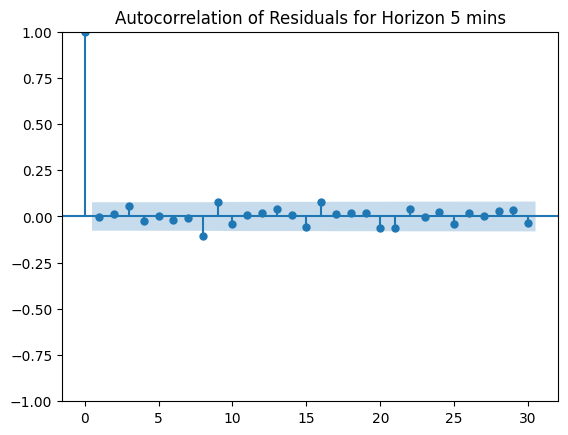

<Figure size 640x480 with 0 Axes>

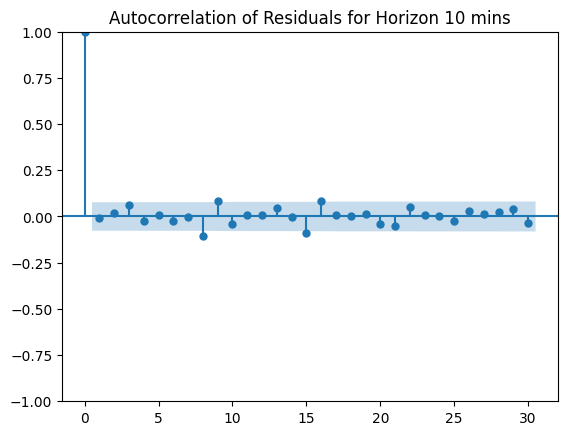

<Figure size 640x480 with 0 Axes>

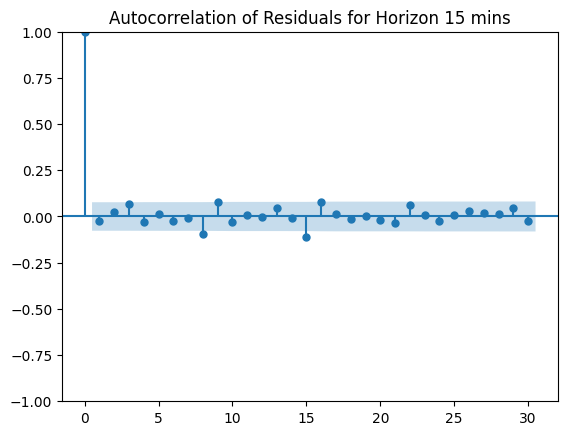

<Figure size 640x480 with 0 Axes>

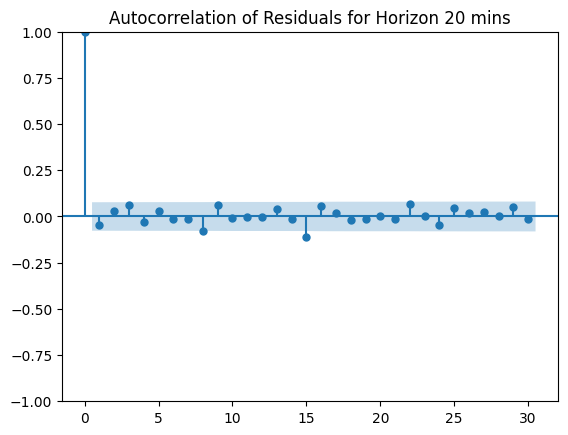

<Figure size 640x480 with 0 Axes>

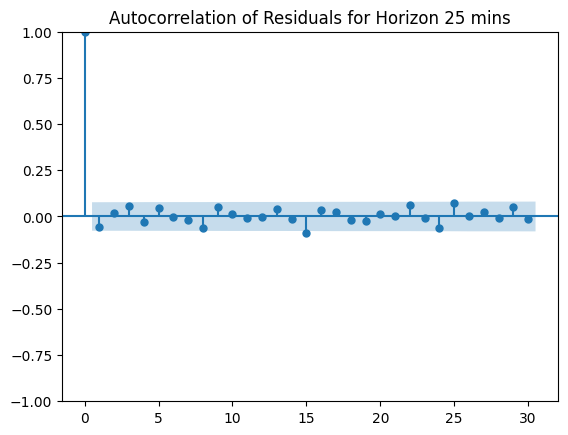

<Figure size 640x480 with 0 Axes>

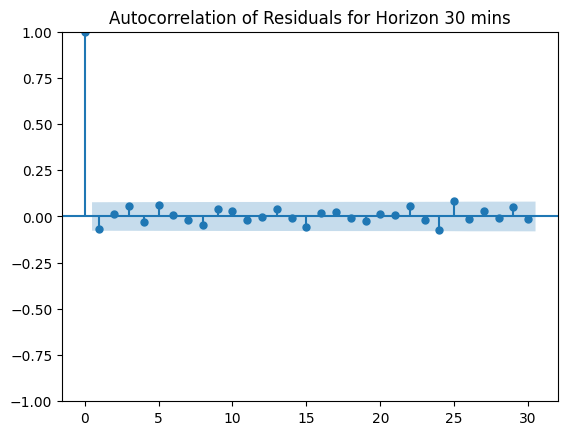

<Figure size 640x480 with 0 Axes>

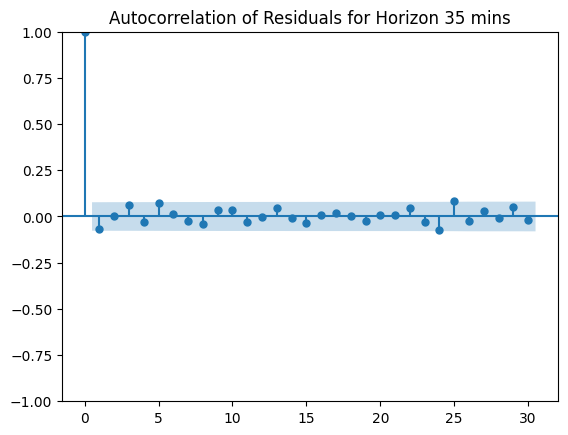

<Figure size 640x480 with 0 Axes>

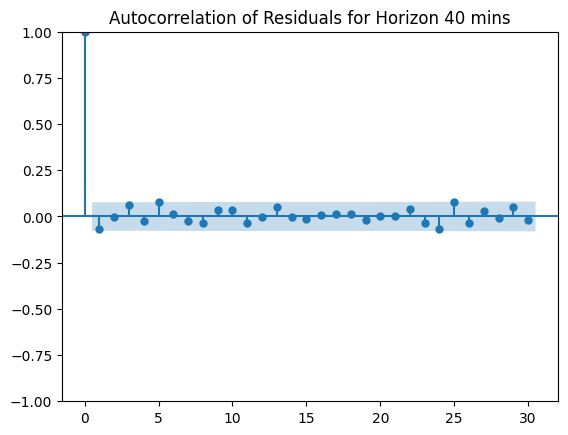

<Figure size 640x480 with 0 Axes>

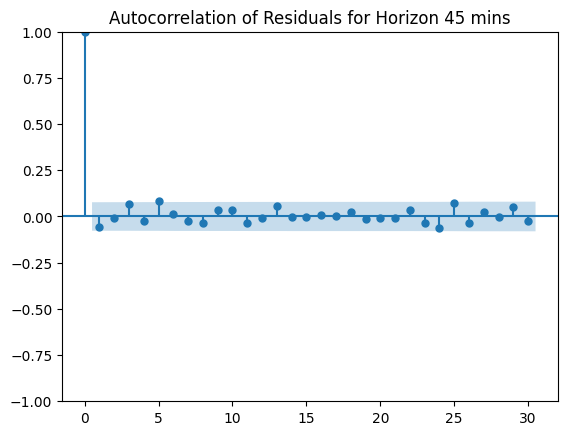

<Figure size 640x480 with 0 Axes>

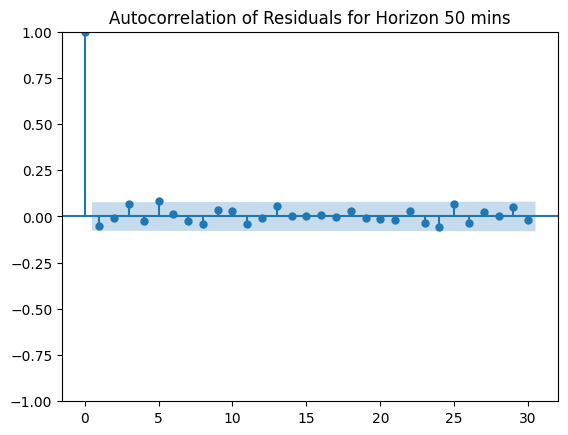

<Figure size 640x480 with 0 Axes>

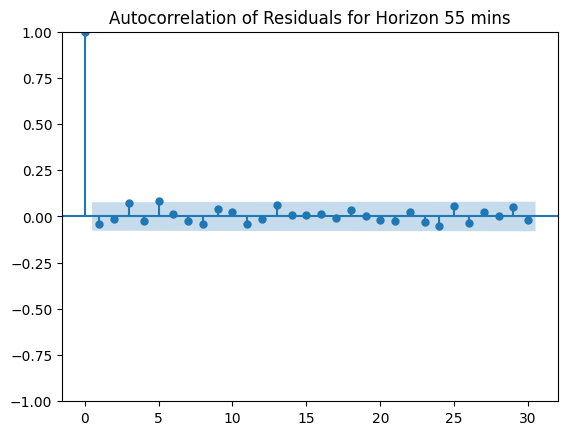

<Figure size 640x480 with 0 Axes>

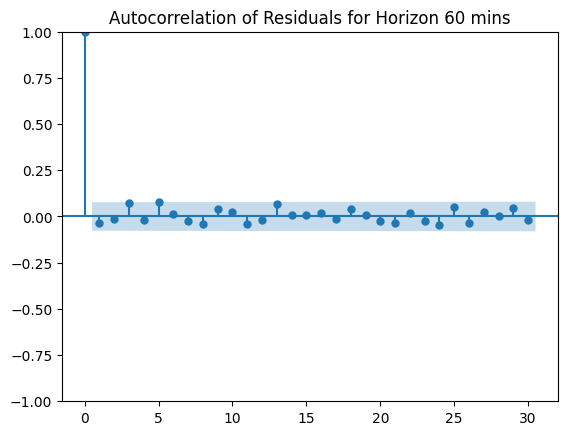

<Figure size 640x480 with 0 Axes>

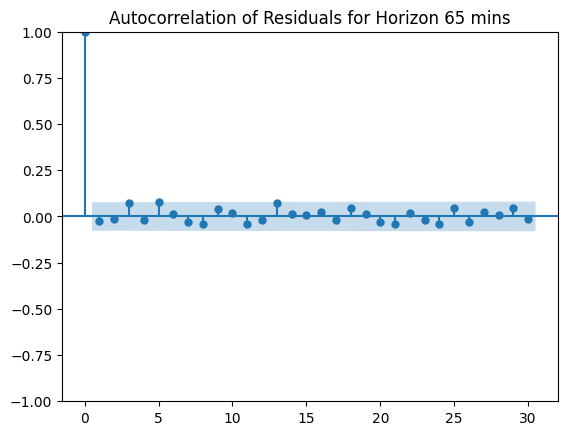

<Figure size 640x480 with 0 Axes>

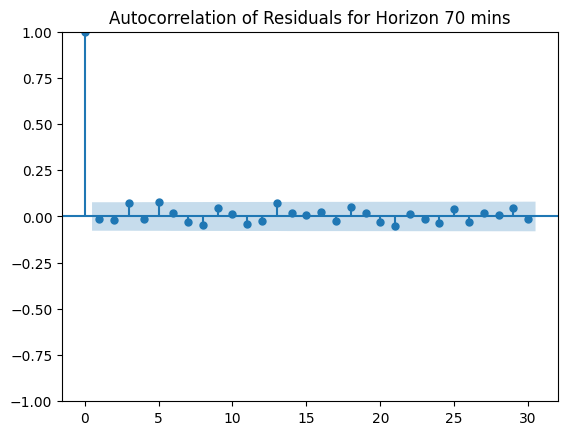

<Figure size 640x480 with 0 Axes>

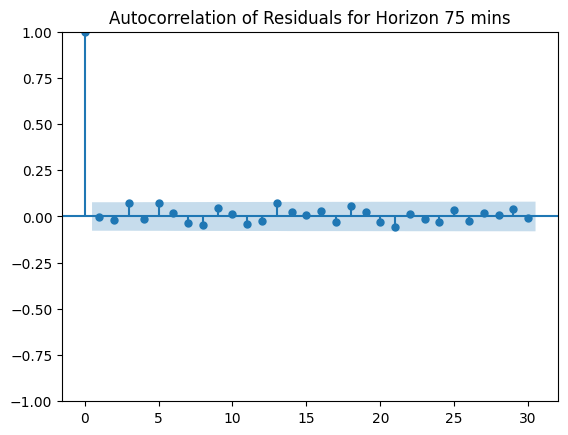

<Figure size 640x480 with 0 Axes>

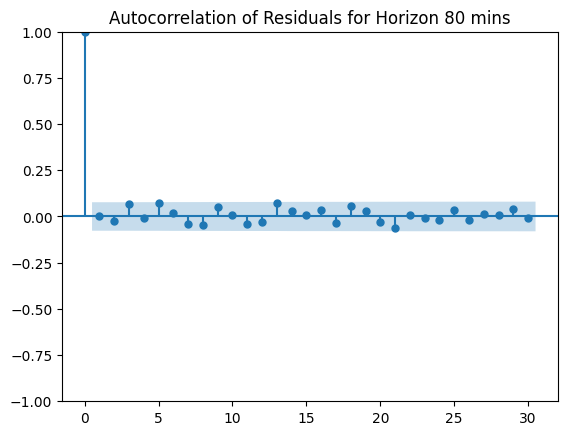

<Figure size 640x480 with 0 Axes>

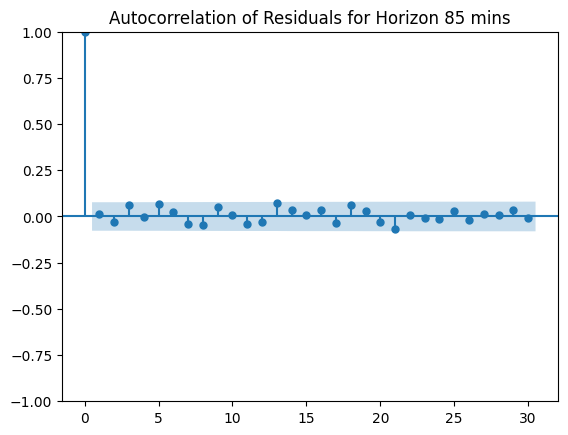

<Figure size 640x480 with 0 Axes>

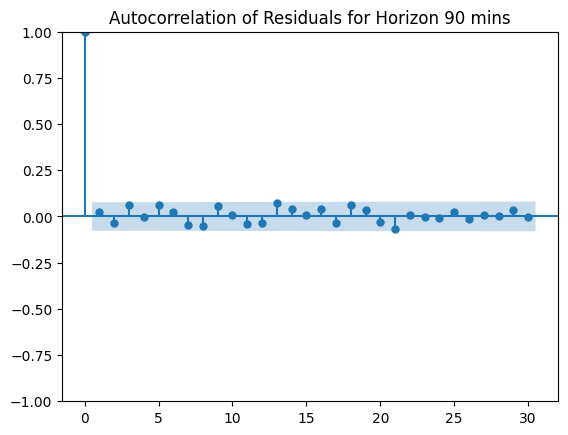

<Figure size 640x480 with 0 Axes>

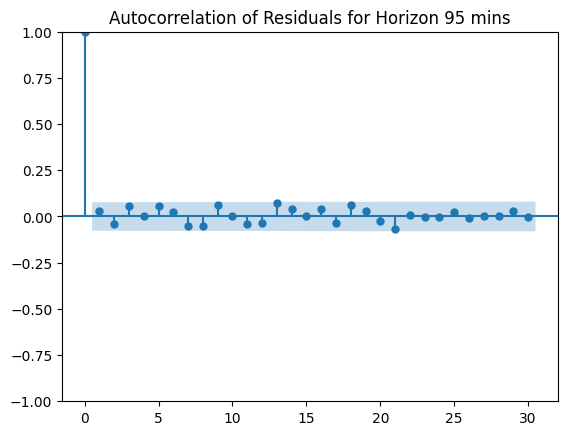

<Figure size 640x480 with 0 Axes>

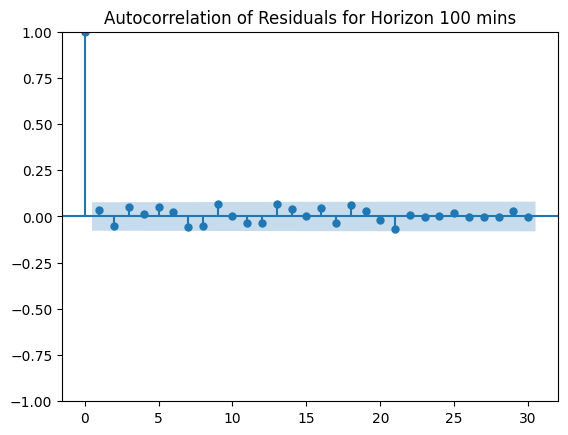

<Figure size 640x480 with 0 Axes>

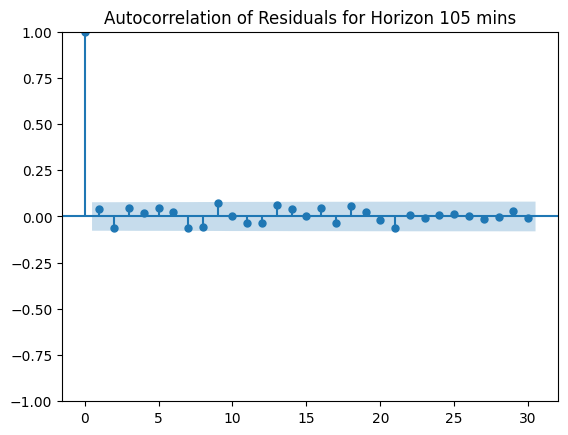

<Figure size 640x480 with 0 Axes>

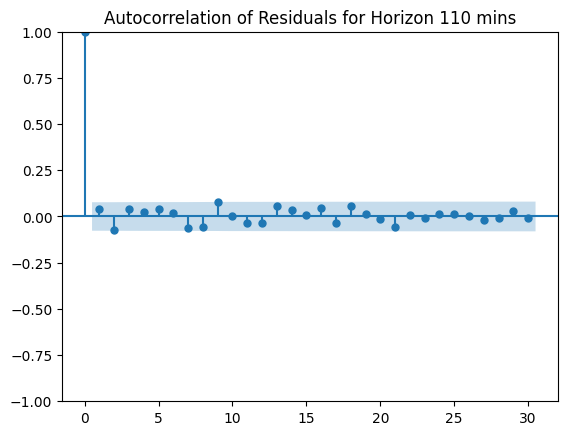

<Figure size 640x480 with 0 Axes>

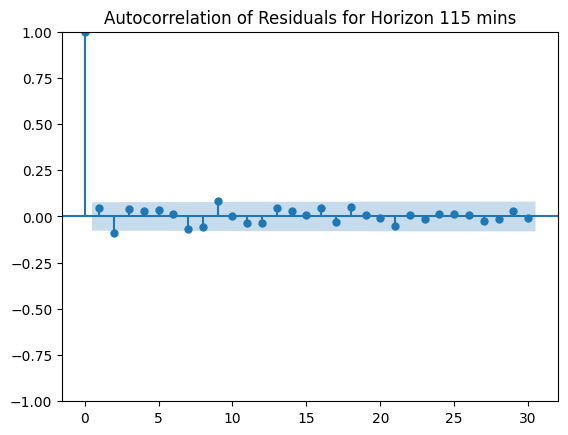

<Figure size 640x480 with 0 Axes>

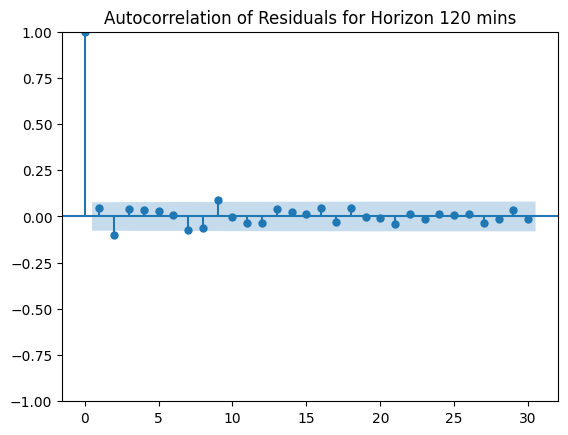

In [137]:
from statsmodels.graphics.tsaplots import plot_acf

for i, h in enumerate(horizons):
    plt.figure()
    plot_acf(residuals_per_horizon[f"Horizon_{h}"], lags=30)
    plt.title(f'Autocorrelation of Residuals for Horizon {h} mins')
    plt.show()
